# Project

### Goal: Improve our original estimate of the log error by using clustering methodologies.

## Acquisition, Prep, and Initial Exploration

In [44]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np

# Exploring
import scipy.stats as stats

# Impute missing values
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# default pandas decimal number display format
pd.options.display.float_format = '{:20,.2f}'.format
pd.set_option('display.max_columns', None, 'display.max_rows', None)

import acquire
import wrangle_zillow
import zillow_fe
import explore
import acquire_r
from env import google_key, google_key1
import gmaps
from googlemaps import convert
from sklearn.model_selection import train_test_split
import scipy.stats as stats

In [2]:
#zillow = acquire.get_zillow(acquire.sql)
#Save file to csv to quit asking the server for this data
#zillow.to_csv('zillow.csv')
zillow = pd.read_csv('zillow.csv', index_col='id')
orig_rows = zillow.shape[0]
orig_cols = zillow.shape[1]
print (f'There are {orig_rows} rows and {orig_cols} columns in the starting dataframe.')

There are 77575 rows and 67 columns in the starting dataframe.


In [3]:
zillow.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1087254,10711855,nan,nan,nan,2.00,3.00,nan,8.00,2.00,nan,nan,"2,107.00","2,107.00",nan,nan,nan,nan,"6,037.00",nan,2.00,nan,nan,nan,2.00,"34,222,559.00","-118,617,387.00","9,158.00",1.00,nan,nan,nan,1.00,0101,261.00,LARE9,"60,371,132.32","12,447.00","3,101.00","268,588.00","96,339.00",0.00,nan,nan,nan,1.00,nan,nan,"1,972.00",nan,nan,"249,655.00","624,139.00","2,016.00","374,484.00","7,659.36",NaN,nan,"60,371,132,321,007.00",-0.01,2017-07-07,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
1072280,10711877,1.00,nan,nan,2.00,4.00,nan,8.00,2.00,nan,nan,"1,882.00","1,882.00",nan,nan,nan,nan,"6,037.00",nan,2.00,nan,nan,nan,2.00,"34,220,261.00","-118,616,409.00","9,035.00",1.00,nan,nan,nan,1.00,0101,261.00,LARE9,"60,371,132.32","12,447.00","3,101.00","268,588.00","96,339.00",0.00,nan,nan,nan,1.00,nan,nan,"1,972.00",nan,nan,"253,000.00","660,000.00","2,016.00","407,000.00","8,123.91",NaN,nan,"60,371,132,321,007.00",0.02,2017-08-29,Central,NaN,NaN,Central,Single Family Residential,NaN,NaN
1340933,10711888,1.00,nan,nan,2.00,4.00,nan,8.00,2.00,nan,nan,"1,882.00","1,882.00",nan,nan,nan,nan,"6,037.00",nan,2.00,nan,nan,nan,2.00,"34,222,491.00","-118,616,854.00","9,800.00",nan,nan,nan,nan,nan,0100,261.00,LARE9,"60,371,132.32","12,447.00","3,101.00","268,588.00","96,339.00",0.00,nan,nan,nan,1.00,nan,nan,"1,972.00",nan,nan,"257,591.00","542,923.00","2,016.00","285,332.00","6,673.24",NaN,nan,"60,371,132,321,007.00",0.08,2017-04-04,Central,NaN,NaN,Central,Single Family Residential,NaN,NaN
1878109,10711910,nan,nan,nan,2.00,3.00,nan,8.00,2.00,nan,nan,"1,477.00","1,477.00",nan,nan,nan,nan,"6,037.00",nan,2.00,nan,nan,nan,2.00,"34,221,864.00","-118,615,739.00","11,285.00",1.00,nan,nan,nan,1.00,0101,261.00,LARE11,"60,371,132.32","12,447.00","3,101.00","268,588.00","96,339.00",0.00,nan,nan,nan,1.00,nan,nan,"1,960.00",nan,nan,"57,968.00","78,031.00","2,016.00","20,063.00","1,116.46",NaN,nan,"60,371,132,321,008.00",-0.04,2017-03-17,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
2190858,10711923,nan,nan,nan,2.00,4.00,nan,8.00,2.00,nan,nan,"1,918.00","1,918.00",nan,nan,nan,nan,"6,037.00",nan,2.00,nan,nan,nan,2.00,"34,220,619.00","-118,615,253.00","11,239.00",1.00,nan,nan,nan,1.00,0101,261.00,LARE11,"60,371,132.32","12,447.00","3,101.00","268,588.00","96,339.00",0.00,nan,nan,nan,1.00,nan,nan,"1,960.00",nan,nan,"167,869.00","415,459.00","2,016.00","247,590.00","5,239.85",NaN,nan,"60,371,132,321,008.00",-0.01,2017-03-24,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN


In [4]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77575 entries, 1087254 to 2535331
Data columns (total 67 columns):
parcelid                        77575 non-null int64
airconditioningtypeid           25006 non-null float64
architecturalstyletypeid        206 non-null float64
basementsqft                    50 non-null float64
bathroomcnt                     77575 non-null float64
bedroomcnt                      77575 non-null float64
buildingclasstypeid             15 non-null float64
buildingqualitytypeid           49809 non-null float64
calculatedbathnbr               76960 non-null float64
decktypeid                      614 non-null float64
finishedfloor1squarefeet        6035 non-null float64
calculatedfinishedsquarefeet    77375 non-null float64
finishedsquarefeet12            73920 non-null float64
finishedsquarefeet13            42 non-null float64
finishedsquarefeet15            3027 non-null float64
finishedsquarefeet50            6035 non-null float64
finishedsquarefeet6  

### Issues

- Some observations are not single-use properties
    - Restrict df to only single_use 
    - Restrict df to properties with at least 1 bedroom & bathroom
- Null and missing values
    - Fill nulls with zero where appropriate
        - ['airconditioningtypeid', 'basementsqft', 'decktypeid', 'fireplacecnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa', 'lotsizesquarefeet', 'poolcnt', 'poolsizesum', 'taxdelinquencyyear']
    - Fill nulls with median value where appropriate
        - ['heatingorsystemtypeid', 'numberofstories', 'unitcnt']
- Outliers
    - Restrict df to only those values within 3 std deviations of the mean (z-score)
- Zip codes are not correct
    - Ravinder's impute function adds a new column with correct zipcode and the median income for that zipcode
- Fips column is meaningless without county names
    - Add column for county
- Multiple columns we won't use
    - drop columns
- column types are wrong
    - change column types

In [5]:
zillow = wrangle_zillow.wrangle_zillow()
# Save file to csv
zillow.to_csv('zillow_reduced.csv')

In [6]:
new_rows = zillow.shape[0]
new_cols = zillow.shape[1]
print (f'There were {orig_rows} rows and {orig_cols} columns in the starting dataframe.')
print (f'There are {new_rows} rows and {new_cols} columns in the modified dataframe.')

There were 77575 rows and 67 columns in the starting dataframe.
There are 64786 rows and 36 columns in the modified dataframe.


### Feature Engineering

1. Add new features calculated from existing
    - age: 2017 - yearbuilt
    - tax_rate: taxamount / taxvalue
    - cost_structure_sf: taxvalue / squarefeet
    - is_extra: how many extra features property has
    
    
2. One hot encode county columns

In [7]:
zillow = zillow_fe.calculated_features(zillow)

3. Bin features into 6 bins
    - sf_bin
    - age_bin
    - tax_bin

In [8]:
zillow = zillow_fe.bin_features(zillow)

4. Cluster features
    - Combine buildingquality, roomcnt & is_extra into 6 clusters
    - Combine lotsize, landtaxvalue & zipcode into 6 clusters

In [9]:
zillow = zillow_fe.cluster_features(zillow, 6)

5. Drop unnecessary columns

In [10]:
zillow = zillow_fe.drop_unnecessary_features(zillow)
# Binning created NaNs, drop them for now
zillow = zillow.dropna()

In [11]:
new_rows = zillow.shape[0]
new_cols = zillow.shape[1]
print (f'There were {orig_rows} rows and {orig_cols} columns in the starting dataframe.')
print (f'There are {new_rows} rows and {new_cols} columns in the modified dataframe.')

There were 77575 rows and 67 columns in the starting dataframe.
There are 64747 rows and 46 columns in the modified dataframe.


In [12]:
# Save zillow to csv for use in modeling
zillow.to_csv('zillow_fe.csv')

## Explore

### Feature Distributions

RuntimeError: Selected KDE bandwidth is 0. Cannot estimate density.

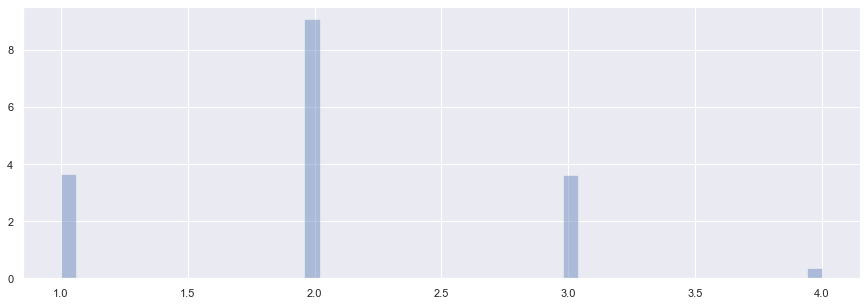

In [13]:
plt.figure(figsize=(15,5))
sns.distplot(zillow.bathroomcnt)

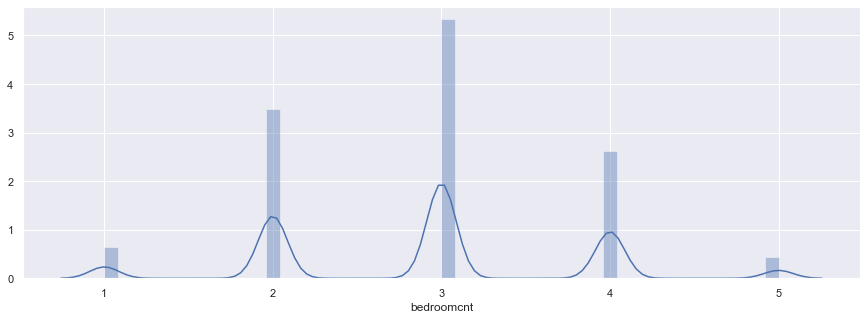

In [14]:
plt.figure(figsize=(15,5))
sns.distplot(zillow.bedroomcnt)

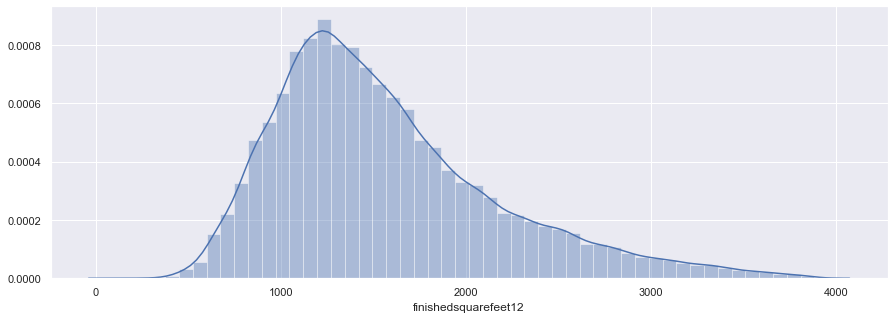

In [15]:
plt.figure(figsize=(15,5))
sns.distplot(zillow.finishedsquarefeet12)

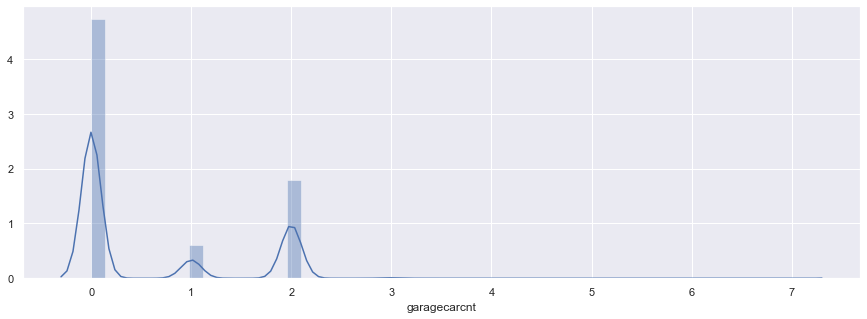

In [16]:
plt.figure(figsize=(15,5))
sns.distplot(zillow.garagecarcnt)

RuntimeError: Selected KDE bandwidth is 0. Cannot estimate density.

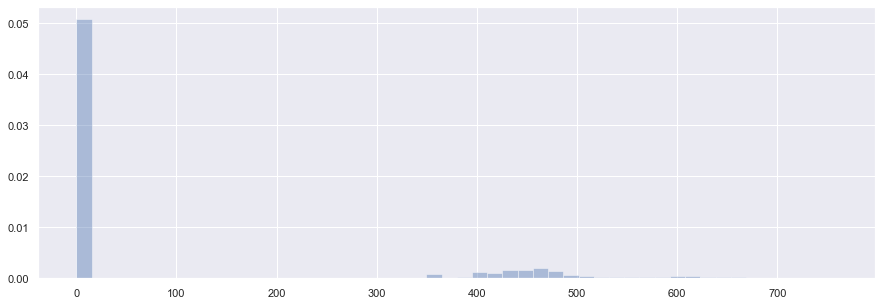

In [17]:
plt.figure(figsize=(15,5))
sns.distplot(zillow.garagetotalsqft)

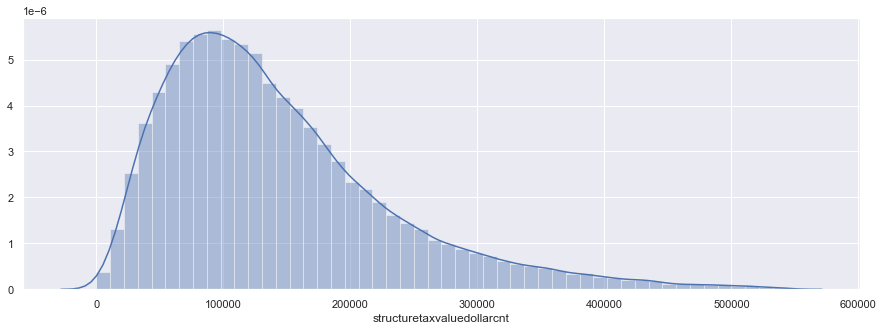

In [24]:
plt.figure(figsize=(15,5))
sns.distplot(zillow.structuretaxvaluedollarcnt)

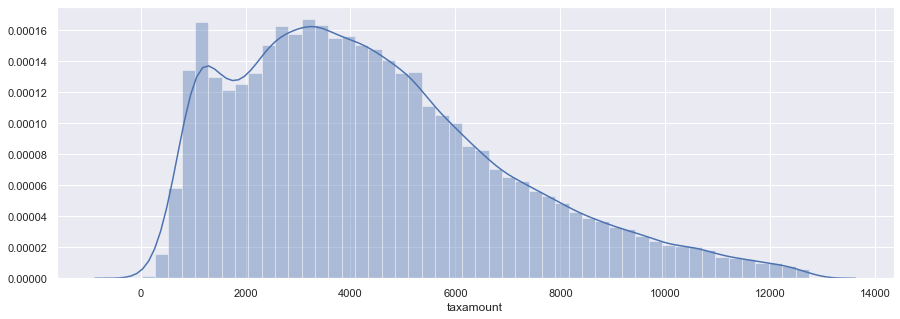

In [25]:
plt.figure(figsize=(15,5))
sns.distplot(zillow.taxamount)

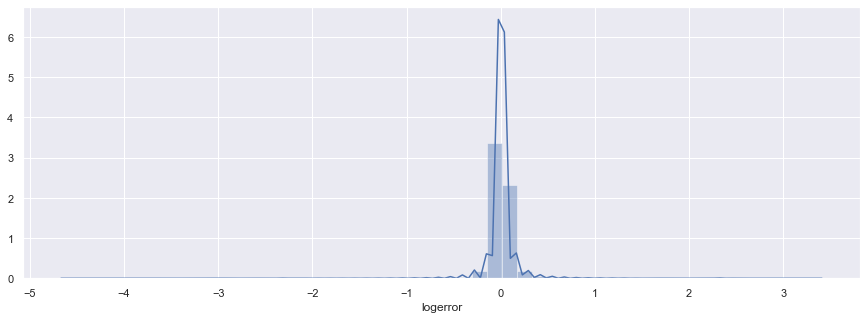

In [26]:
plt.figure(figsize=(15,5))
sns.distplot(zillow.logerror)

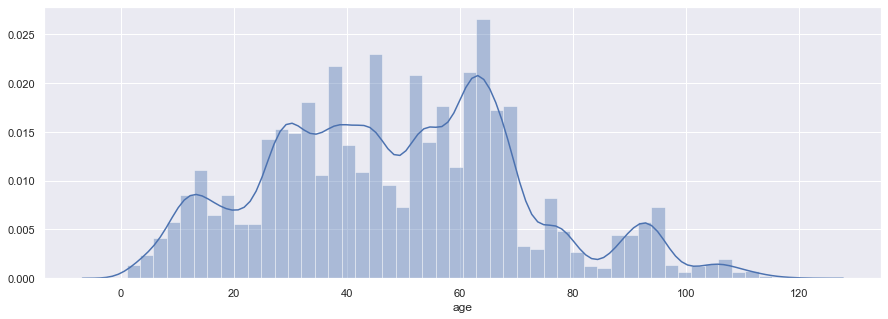

In [27]:
plt.figure(figsize=(15,5))
sns.distplot(zillow.age)

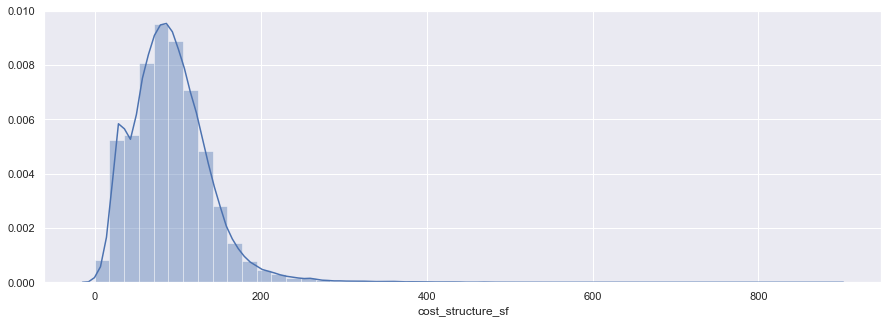

In [28]:
plt.figure(figsize=(15,5))
sns.distplot(zillow.cost_structure_sf)

### Extra Features

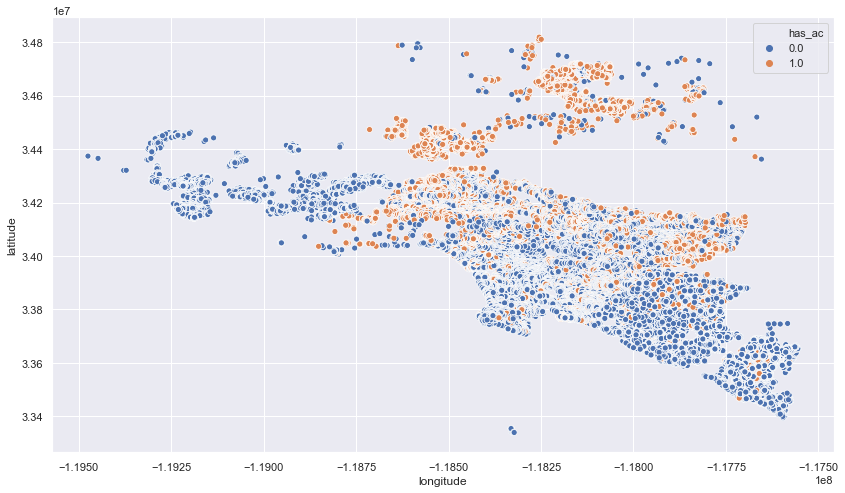

In [29]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='longitude', y='latitude', hue=(zillow.has_ac).astype('float'), data=zillow)

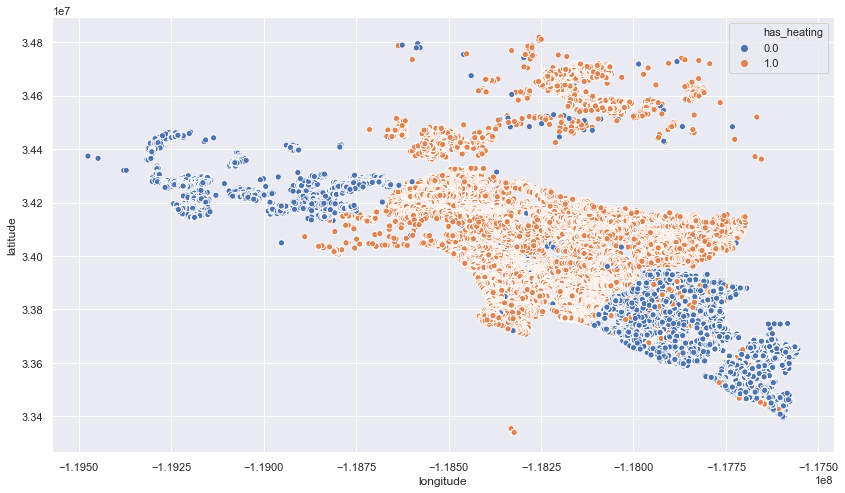

In [30]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='longitude', y='latitude', hue=(zillow.has_heating).astype('float'), data=zillow)

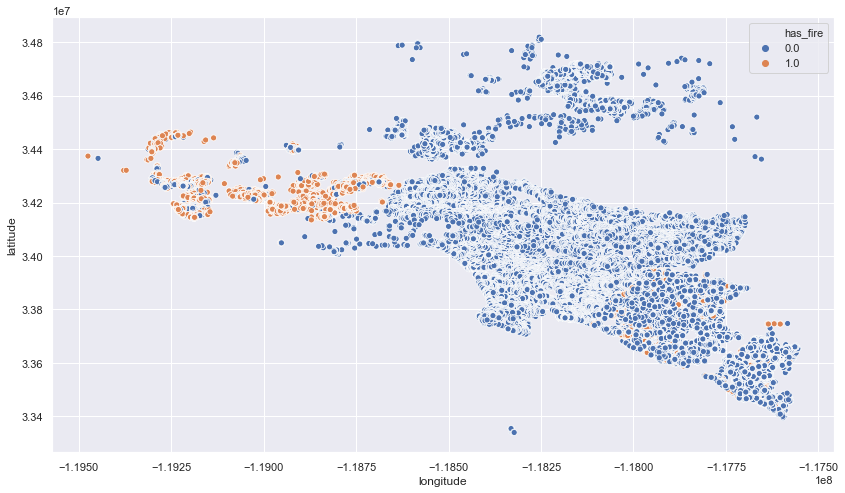

In [31]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='longitude', y='latitude', hue=(zillow.has_fire).astype('float'), data=zillow)

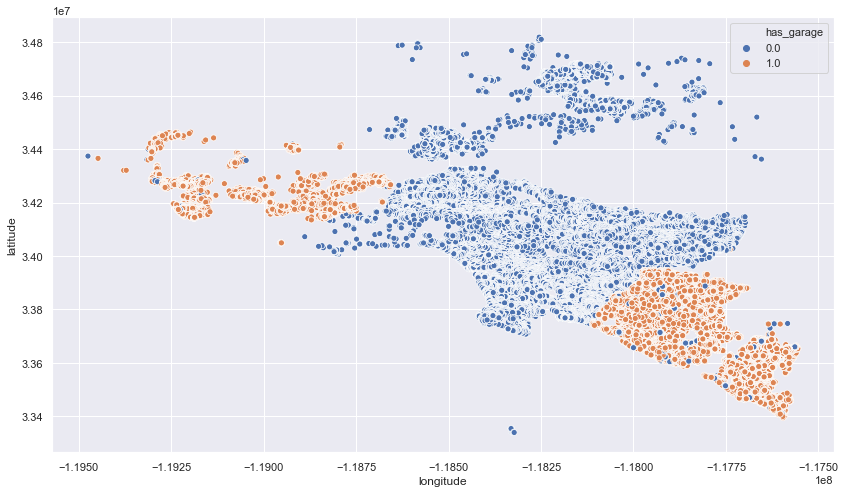

In [32]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='longitude', y='latitude', hue=(zillow.has_garage).astype('float'), data=zillow)

### Calculated Features

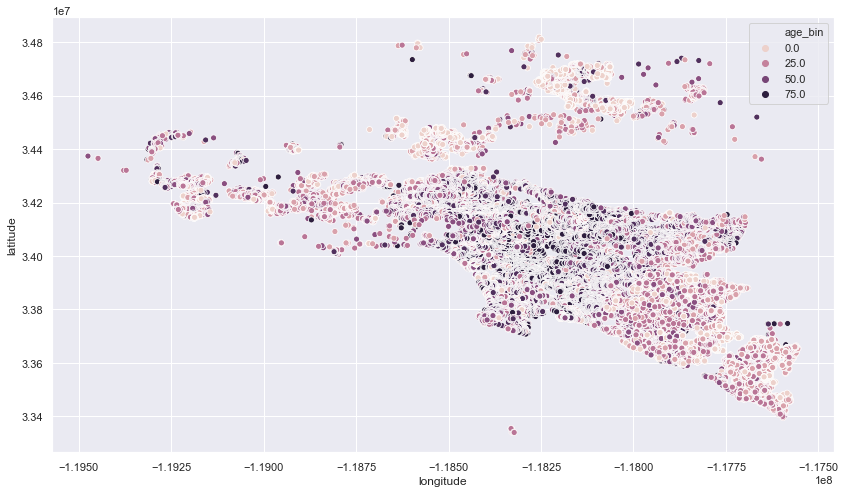

In [18]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='longitude', y='latitude', hue=(zillow.age_bin).astype('float'), data=zillow)

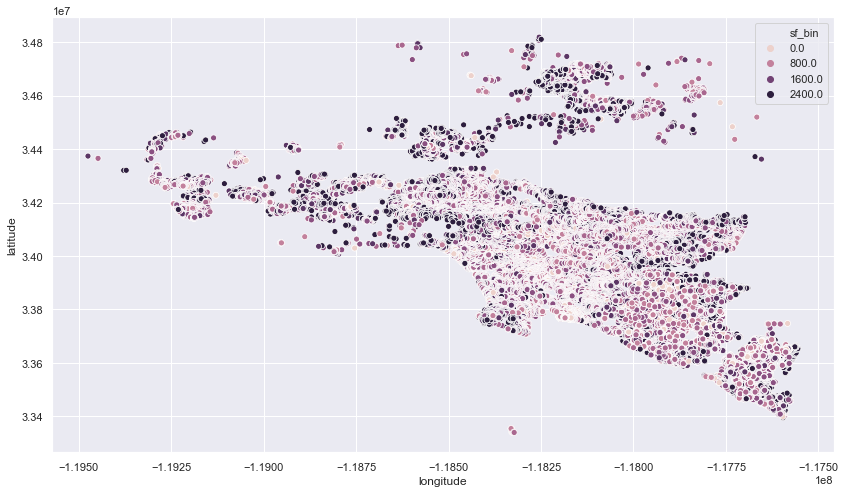

In [19]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='longitude', y='latitude', hue=(zillow.sf_bin).astype('float'), data=zillow)

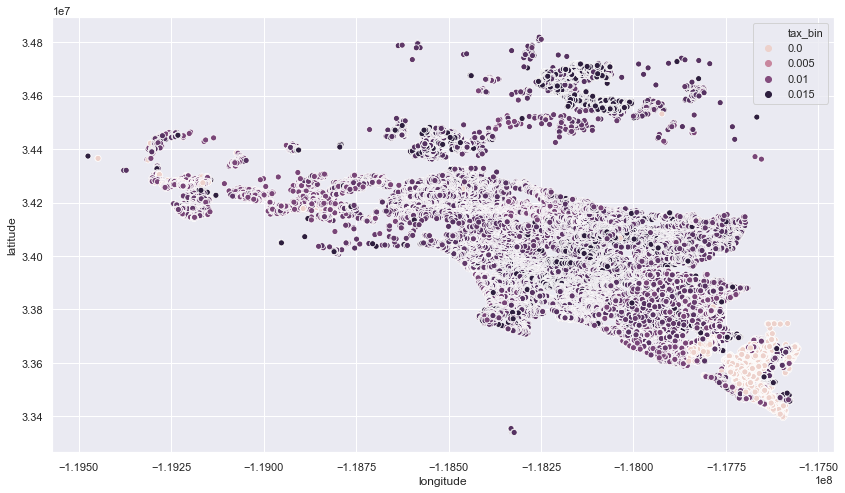

In [20]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='longitude', y='latitude', hue=(zillow.tax_bin).astype('float'), data=zillow)

### Clustered Features

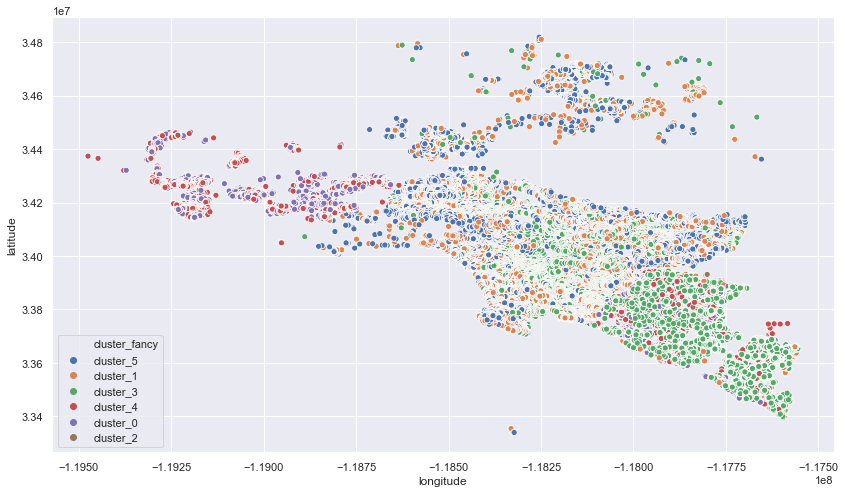

In [21]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='longitude', y='latitude', hue=zillow.cluster_fancy, data=zillow)

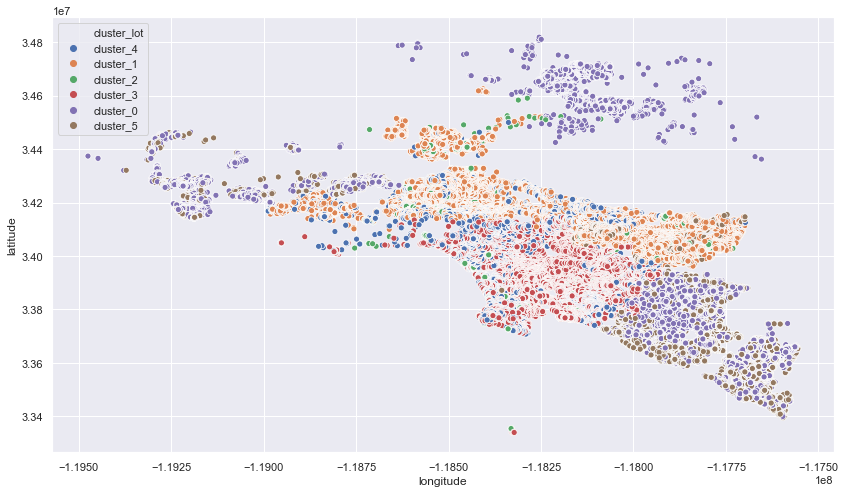

In [22]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='longitude', y='latitude', hue=zillow.cluster_lot, data=zillow)

In [16]:
train, test = train_test_split(zillow, train_size = .80, random_state = 539)
train, validate = train_test_split(train, train_size = .80, random_state = 539)    


In [ ]:
X = train[['logerror']]
train, X_scaled, scaler, kmeans, centroids = explore.cluster(train, X, 5)

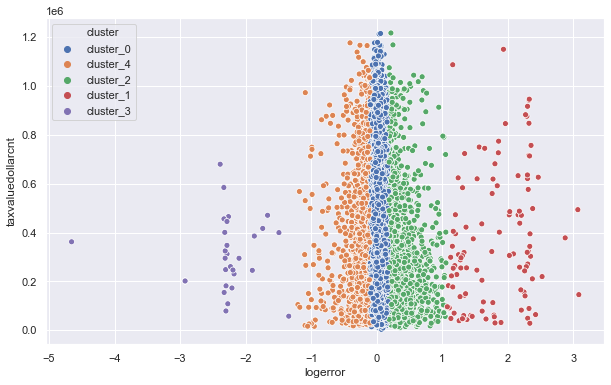

In [18]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x = 'logerror', y = 'taxvaluedollarcnt', data = train, hue = 'cluster')

### It seems that log error has much wider distribution at lower values houses
***

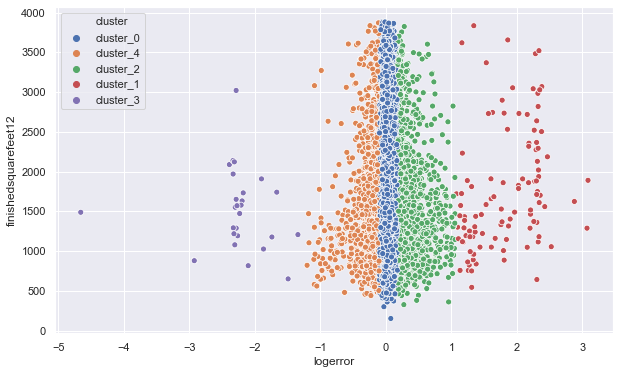

In [19]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x = 'logerror', y = 'finishedsquarefeet12', data = train, hue = 'cluster')

###  logerror has much higher spread smaller sized houses
***

### clustering by independent variables

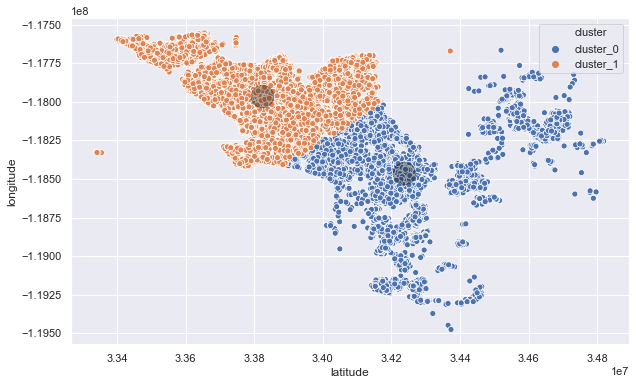

In [34]:
X = train[['latitude', 'longitude', 'logerror']]
train, X_scaled, scaler, kmeans, centroids = explore.cluster(train, X, 2)
explore.scatter_plot('latitude','longitude',train,kmeans, X_scaled, scaler)

In [35]:
#Lets look at logerror means for two clusters
print(train[train.cluster == 'cluster_0'].logerror.mean())
print(train[train.cluster == 'cluster_1'].logerror.mean())
#print(train[train.cluster == 'cluster_2'].logerror.mean())

0.009547360140518163
0.01833371670797886


##### Lets do a t-test to see if these two clusters are statistically different from each other
$H_0$: The two clusters have similar mean logerror\
$H_a$: The two clusters have different mean logerror



In [36]:
# Lets do a t-test to see if these two clusters are statistically different from each other
x1 = train[train.cluster == 'cluster_0'].logerror
x2 = train[train.cluster == 'cluster_1'].logerror
stats.ttest_ind(x1, x2)

Ttest_indResult(statistic=-5.432807524668256, pvalue=5.578604053986223e-08)

##### Since the p value is almost zero, we reject the null hypothesis. This tells us that the two clusters have statistically significant difference in mean logerros



### Now we will explore finished square feet and logmean error

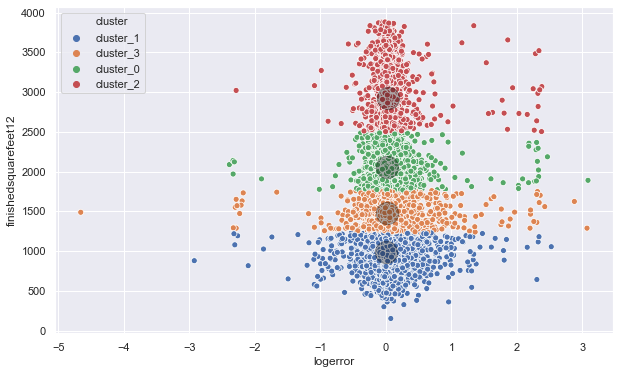

In [38]:
X = train[['finishedsquarefeet12','logerror']]
train, X_scaled, scaler, kmeans, centroids = explore.cluster(train, X, 4)
explore.scatter_plot('logerror','finishedsquarefeet12',train,kmeans, X_scaled, scaler)

In [40]:
print(train[train.cluster == 'cluster_0'].logerror.mean())
print(train[train.cluster == 'cluster_1'].logerror.mean())
print(train[train.cluster == 'cluster_2'].logerror.mean())
print(train[train.cluster == 'cluster_3'].logerror.mean())

0.01866392631906387
0.008393674534701473
0.028754158661179505
0.014197030289089523


##### Lets do a t-test to see if these  clusters are statistically different from each other
$H_0$: The clusters have similar mean logerror\
$H_a$: The clusters have different mean logerror



In [46]:
stats.f_oneway(train[train.cluster == 'cluster_0'].logerror, train[train.cluster == 'cluster_0'].logerror,\
               train[train.cluster == 'cluster_2'].logerror, train[train.cluster == 'cluster_3'].logerror)

F_onewayResult(statistic=8.369897587884033, pvalue=1.4705298366312553e-05)